In [28]:
import random
import os
def generate_data(nodes_number, x_range, y_range, seed):
    if seed is not None:
        random.seed(seed)

    data = []
    used_coordinates = set()

    while len(data) < nodes_number:
        x = random.randint(x_range[0], x_range[1])
        y = random.randint(y_range[0], y_range[1])

        if (x, y) not in used_coordinates:
            used_coordinates.add((x, y))
            data.append((len(data) + 1, x, y))
    return data


# Function to write the generated data to a file
def write_to_file(filename, data):
    with open(filename, "w") as f:
        for entry in data:
            f.write(f"{entry[0]} {entry[1]} {entry[2]}\n")


NODES_NUMBER = 3000
X_RANGE = (0, 1000)
Y_RANGE = (0, 1000)
SEED = 1
data = generate_data(NODES_NUMBER, X_RANGE, Y_RANGE, SEED)


filename = "TSP.txt"
if os.path.exists(filename):
    os.remove(filename)

write_to_file(filename, data)

print(f"Randomly generated '{NODES_NUMBER}' Cities and written to '{filename}'")

Randomly generated '3000' Cities and written to 'TSP.txt'


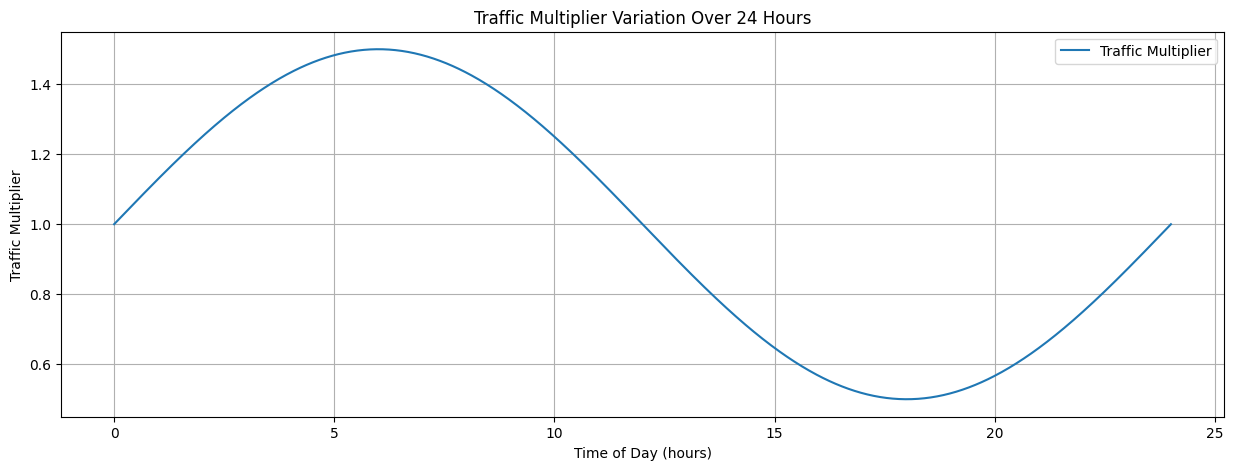

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters for the sine function representing traffic variations
hours = np.linspace(0, 24, 1000)
TRAFFIC_FUNCTION = 1 + 0.5 * np.sin(hours / 24 * 2 * np.pi)

# Plot the sine function
plt.figure(figsize=(15, 5))
plt.plot(hours, TRAFFIC_FUNCTION, label="Traffic Multiplier")
plt.xlabel("Time of Day (hours)")
plt.ylabel("Traffic Multiplier")
plt.title("Traffic Multiplier Variation Over 24 Hours")
plt.grid(True)
plt.legend()
plt.show()

Initial Solution Cost: 61606.30025057541
Iteration 0: Current Cost = 61606.30025057541, Best Cost = 61606.30025057541
Iteration 10: Current Cost = 61606.30025057541, Best Cost = 61606.30025057541
Iteration 20: Current Cost = 61603.774572619426, Best Cost = 61603.774572619426
Iteration 30: Current Cost = 61592.55260151537, Best Cost = 61592.55260151537
Iteration 40: Current Cost = 61592.55260151537, Best Cost = 61592.55260151537
Iteration 50: Current Cost = 61592.55260151537, Best Cost = 61592.55260151537
Iteration 60: Current Cost = 61592.55260151537, Best Cost = 61592.55260151537
Iteration 70: Current Cost = 61590.137655500264, Best Cost = 61590.137655500264
Iteration 80: Current Cost = 61575.116434559786, Best Cost = 61575.116434559786
Iteration 90: Current Cost = 61575.116434559786, Best Cost = 61575.116434559786
Iteration 100: Current Cost = 61463.14790821232, Best Cost = 61463.14790821232
Iteration 110: Current Cost = 61444.622760396756, Best Cost = 61444.622760396756
Iteration 12

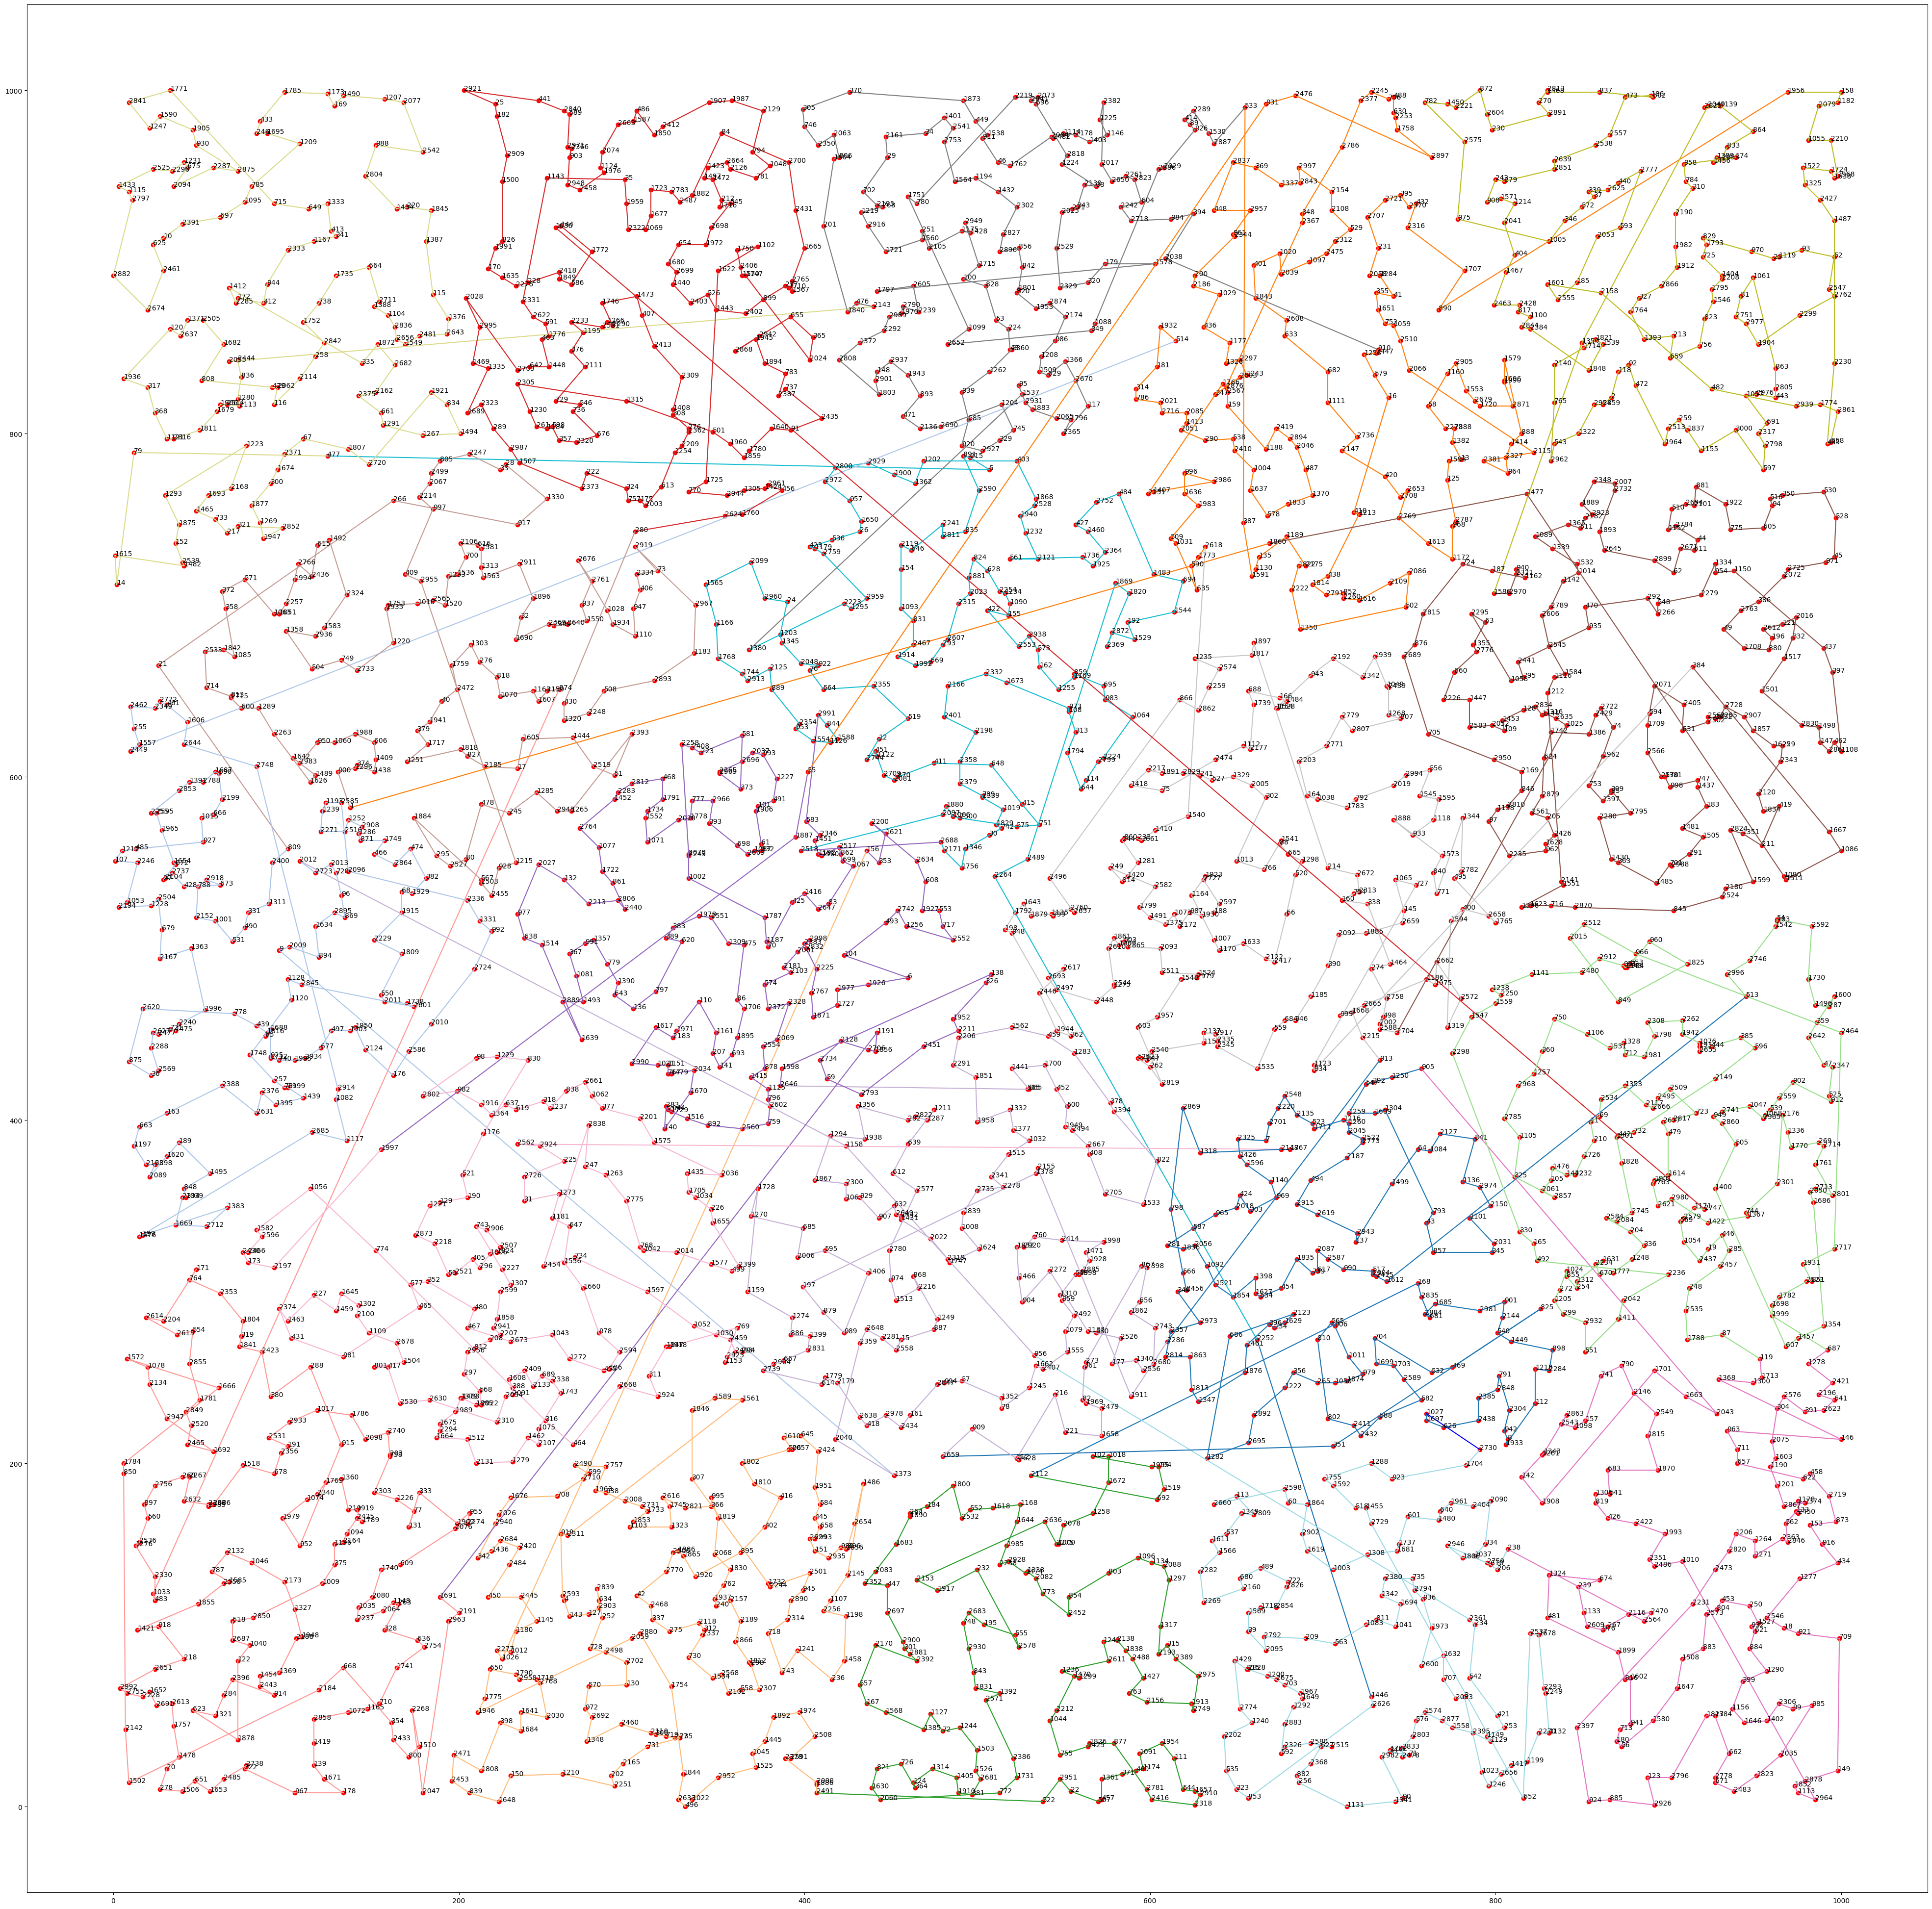

In [30]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from itertools import cycle
from collections import deque
import os

# Define the environment variable
os.environ["OMP_NUM_THREADS"] = "2"

# Reading cities
def get_city():
    cities = []
    with open("TSP.txt") as f:
        for i in f.readlines():
            node_city_val = i.split()
            cities.append([node_city_val[0], float(node_city_val[1]), float(node_city_val[2])])
    return cities

# Calculate travel time
def calculate_travel_time(cityA, cityB, time):
    base_distance = math.sqrt(
        math.pow(cityB[1] - cityA[1], 2) + math.pow(cityB[2] - cityA[2], 2)
    )
    traffic_multiplier = 1 + 0.5 * np.sin(time / 24 * 2 * np.pi)
    travel_time = base_distance * traffic_multiplier
    return travel_time

# Precompute distances
def calculate_distance_matrix(cities):
    n = len(cities)
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            distance = calculate_travel_time(cities[i], cities[j], 0)
            distance_matrix[i][j] = distance
            distance_matrix[j][i] = distance
    return distance_matrix

# Calculate total time
def calculate_total_time(solution, distance_matrix):
    total_time = 0
    for i in range(len(solution) - 1):
        cityA = solution[i]
        cityB = solution[i + 1]
        total_time += distance_matrix[cityA][cityB]
    cityA = solution[0]
    cityB = solution[-1]
    total_time += distance_matrix[cityB][cityA]
    return total_time

# K-means clustering function
def cluster_cities(cities, k):
    coordinates = np.array([[city[1], city[2]] for city in cities])
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0).fit(coordinates)
    clusters = [[] for _ in range(k)]
    for idx, label in enumerate(kmeans.labels_):
        clusters[label].append(idx)
    return clusters, kmeans.labels_

# Generate an optimal path for each cluster
def nearest_neighbor_path(cluster, distance_matrix):
    unvisited = set(cluster)
    path = [unvisited.pop()]
    while unvisited:
        nearest_city = min(unvisited, key=lambda city: distance_matrix[path[-1]][city])
        path.append(nearest_city)
        unvisited.remove(nearest_city)
    return path

# Connect clusters
def connect_clusters(clusters, distance_matrix):
    paths = []
    for cluster in clusters:
        path = nearest_neighbor_path(cluster, distance_matrix)
        paths.append(path)
    connected_path = [city for path in paths for city in path]
    return connected_path

# Generate a more diversified initial solution using a greedy approach
def generate_initial_solution(cities, distance_matrix):
    clusters, labels = cluster_cities(cities, K_CLUSTERS)
    solution = connect_clusters(clusters, distance_matrix)
    return solution, labels

# Enhanced neighborhood generation with multiple types of moves
def generate_neighbors(solution, distance_matrix, sample_size):
    neighbors = []
    for _ in range(sample_size):
        neighbor = solution[:]
        move_type = random.choice(["swap", "reverse", "insert"])
        if move_type == "swap":
            i, j = random.sample(range(1, len(neighbor)), 2)
            neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
        elif move_type == "reverse":
            i, j = sorted(random.sample(range(1, len(neighbor)), 2))
            neighbor[i:j] = reversed(neighbor[i:j])
        elif move_type == "insert":
            i, j = random.sample(range(1, len(neighbor)), 2)
            if i < j:
                neighbor.insert(j, neighbor.pop(i))
            else:
                neighbor.insert(i, neighbor.pop(j))
        neighbors.append((neighbor, calculate_total_time(neighbor, distance_matrix)))
    return neighbors

# Tabu search algorithm with extensive debugging
def tabu_search(initial_solution, distance_matrix, tabu_tenure, iterations, sample_size=100):
    best_solution = initial_solution
    best_cost = calculate_total_time(initial_solution, distance_matrix)
    current_solution = initial_solution
    current_cost = best_cost
    tabu_list = deque(maxlen=tabu_tenure)
    
    print(f"Initial Solution Cost: {best_cost}")

    for iteration in range(iterations):
        neighborhood = generate_neighbors(current_solution, distance_matrix, sample_size)
        neighborhood = sorted(neighborhood, key=lambda x: x[1])
        
        for candidate in neighborhood:
            if tuple(candidate[0]) not in tabu_list:
                current_solution = candidate[0]
                current_cost = candidate[1]
                tabu_list.append(tuple(candidate[0]))
                break
        
        if current_cost < best_cost:
            best_solution = current_solution
            best_cost = current_cost
        else:
            current_solution = best_solution
            current_cost = best_cost
        
        if iteration % 10 == 0:
            print(f"Iteration {iteration}: Current Cost = {current_cost}, Best Cost = {best_cost}")
    
    return best_solution, best_cost

# Draw the map with different colors for each cluster
def drawMap(cities, path, labels, k):
    plt.figure(figsize=(50, 50))
    colors = cycle(plt.cm.tab20.colors)  # Use a cycle of colors

    for j in range(len(cities)):
        plt.plot(cities[j][1], cities[j][2], "ro")
        plt.annotate(cities[j][0], (cities[j][1], cities[j][2]))

    color_map = {i: next(colors) for i in range(k)}
    for i in range(len(path) - 1):
        first = path[i]
        second = path[i + 1]
        cluster_color = color_map[labels[first]]
        plt.plot([cities[first][1], cities[second][1]], [cities[first][2], cities[second][2]], color=cluster_color)
    first = path[0]
    second = path[-1]
    plt.plot([cities[first][1], cities[second][1]], [cities[first][2], cities[second][2]], "blue")
    plt.show()

# Main function
def main():
    global K_CLUSTERS
    K_CLUSTERS = 20
    TABU_TENURE = 15
    ITERATIONS = 1000

    cities = get_city()
    
    distance_matrix = calculate_distance_matrix(cities)
    initial_solution, labels = generate_initial_solution(cities, distance_matrix)
    
    best_solution, best_cost = tabu_search(initial_solution, distance_matrix, TABU_TENURE, ITERATIONS)
    
    print("\n----------------------------------------------------------------")
    print(f"Initial solution cost: {calculate_total_time(initial_solution, distance_matrix)}")
    print(f"Best solution cost: {best_cost}")
    print("----------------------------------------------------------------\n")
    
    drawMap(cities, best_solution, labels, K_CLUSTERS)

main()
